In [1]:
import sys
import numpy as np 
import pandas as pd
import warnings
import sympy 
import matplotlib as plt
warnings.filterwarnings('ignore')

from copy import deepcopy
from ipywidgets import IntProgress
from IPython.display import display

sys.path.append('./')
sys.path.append('./Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par

#File related libraries
from expression_writter import *

#Writing files libraries
import re
from file_creator import *
import os
import pickle

In [2]:
def plot_graph(xp, yp, probtreefile, savedir, title):
    plt.scatter(xp, yp, alpha = 0.1)
    plt.xlabel("-log(Prob_Tree)")
    plt.ylabel("Descrtiption Length")
    #titleName = probtreefile.split("/")[-1].split("_")[0]
    titleName = title
    plt.title(f"Probability Comparison :{titleName} ")
    savePath = os.path.join(directory, titleName + ".png")
    print(savePath)
    plt.savefig(savePath, dpi = 100, bbox_inches = 'tight')

# M1

In this case the procedure has been the following.
1. Generate a set of expressios with the BMS using a dataset (NGuyen^C)
2. Train a tree with each of these datasets.
3. Compare the probability of generating the expressions in the dataset used for 2 between the trained tree and the BMS.

In [41]:
XLABS = ['x']
parameters = ['_a%d_' % i for i in range(13)]

#creating empty tree and probtree
model = Tree(
    variables = XLABS,
    parameters = parameters,
    from_string = 'x',
    prior_par= read_prior_par("./Prior/final_prior_param_sq.named_equations.nv1.np2.2017-10-18 18:07:35.163458.dat"),
)

#Probability tree
Arbre =ProbTree(
    tree = model,
    parameters = parameters
) 



In [42]:
Arbre.tree
print(-np.log(Arbre.pr_tree()))
model.E

-np.log(Arbre.root.prob_list['_a1_']) \
-np.log(Arbre.root.prob_list['+']) \
-np.log(Arbre.root.prob_list['*']) \
-np.log(Arbre.root.prob_list['x']) \
-np.log(Arbre.root.prob_list['_a0_'])

3.6375861597263857


17.42895155522212

In [43]:
model.E

0.0

In [44]:
ProbTreeFile = "./KL/Probabilty_Trees/GAUSSIAN STEPS/sin(1.5*x)*cos(0.5*z)_nv2_np20_mean0_stddev0.1.txt_GAUSSIAN_STEPS"
#ExpressionFile = "./Results_Leo/Filtered_Datasets/Filetered_ 3.39*x**3 + 2.12*x**2 + 1.78*x_nv1_np10_mean0_stddev0.1.txt"
ExpressionFile = "./Results_Leo/ 3.39*x**3 + 2.12*x**2 + 1.78*x_nv1_np10_mean0_stddev0.1.txt"
directoryPrior = "./Prior/"

./KL/Prob_Comparison/M1/GAUSSIAN STEPS/sin(1.5*x)*cos(0.5*z).png


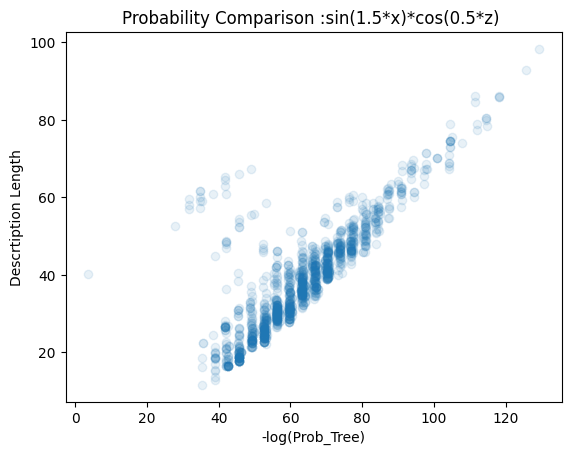

In [49]:
'''
with open(ProbTreeFile, 'rb') as f:
    probTree = pickle.load(f)
'''

all_desc_length_y=[]
all_probtree_prob = []


done = []
with open(ExpressionFile, 'r') as f:
    for line in [l for l in f][:10000]:
        #desc_length , expression = float(line.strip().split("||")[0]) , line.strip().split("||")[1]
        desc_length , expression = float(line.strip().split("||")[1]) , line.strip().split("||")[2]
        if expression not in done:
            done.append(expression)
            all_desc_length_y.append(desc_length)
            Arbre.tree.build_from_string(expression)
            all_probtree_prob.append(Arbre.pr_tree())

minus_log_probtree_x = -1* np.log(all_probtree_prob)
plot_graph(minus_log_probtree_x, all_desc_length_y, probtreefile=ProbTreeFile, savedir="./KL/Prob_Comparison/M1/GAUSSIAN STEPS/")

./KL/Prob_Comparison/M1/GAUSSIAN STEPS/sin(1.5*x)*cos(0.5*z).png


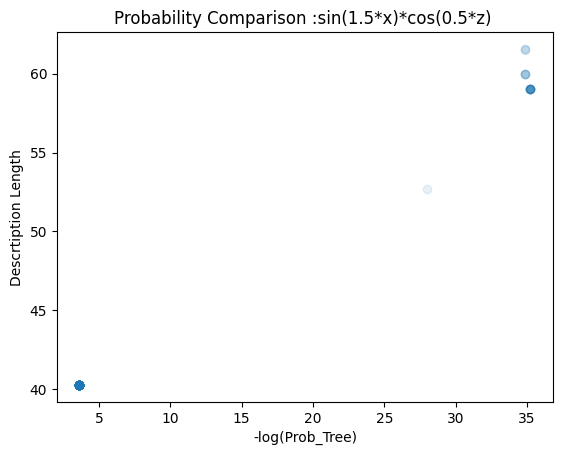

In [46]:
'''
with open(ProbTreeFile, 'rb') as f:
    probTree = pickle.load(f)
'''

all_desc_length_y=[]
all_probtree_prob = []


with open(ExpressionFile, 'r') as f:
    for line in [l for l in f][:100]:
        #desc_length , expression = float(line.strip().split("||")[0]) , line.strip().split("||")[1]
        desc_length , expression = float(line.strip().split("||")[1]) , line.strip().split("||")[2]
        all_desc_length_y.append(desc_length)
        Arbre.tree.build_from_string(expression)
        all_probtree_prob.append(Arbre.pr_tree())

minus_log_probtree_x = -1* np.log(all_probtree_prob)
plot_graph(minus_log_probtree_x, all_desc_length_y, probtreefile=ProbTreeFile, savedir="./KL/Prob_Comparison/M1/GAUSSIAN STEPS/")

# M2

In this case the procedure has been the following.
1. Generate a set of expressios with the BMS using a dataset (NGuyen^C)
2. Train a tree with each of these datasets.
3. With the BMS and the dataset used in 1., create new expressios that were no used to train the tree.
4. Compare probabilities of these new expressions between the tree and the BMS.

The expressions in step 4 will be generated by sampling the BMS with the NGuyen^C dataset and filtering those expressions that already appeared in the training.

In [59]:
ProbTreeFile = "./KL/Probabilty_Trees/GAUSSIAN STEPS/sin(1.5*x)*cos(0.5*z)_nv2_np20_mean0_stddev0.1.txt_GAUSSIAN_STEPS"
old_expressions_file = './Results_Leo/Filtered_Datasets/Filetered_sin(1.5*x)*cos(0.5*z)_nv2_np20_mean0_stddev0.1.txt'
new_expressions_file = './Results_Leo/New_Datasets/sin(1.5*x)*cos(0.5*z)_nv1_np10_mean0_stddev0.1.txt'

In [60]:
with open(old_expressions_file, 'r') as f:
    expressions = set()
    for line in f:
        energy, expression = float(line.split("||")[0]), line.split("||")[1].strip()
        #energ_exp_tuple = (energy, expression)
        #expressions.add(energ_exp_tuple)
        expressions.add(energy)

In [61]:
with open(new_expressions_file, 'r') as f:
    new_expressions = set()
    for line in f:
        energy, expression = float(line.split("||")[1]), line.split("||")[2]
        energ_exp_tuple = (energy, expression)
        if energy not in expressions:
            new_expressions.add(energ_exp_tuple)
            
path = os.path.abspath(new_expressions_file)  
filtered_dir = './Results_Leo/New_Datasets/Filtered_Datasets/'  
filtered_name = f"Filtered_{os.path.basename(path)}"  
filtered_new_expressions_file = os.path.join(filtered_dir, filtered_name)  

with open(filtered_new_expressions_file, 'w') as f:
    for ele in new_expressions:
        f.write(f"{ele[0]}||{ele[1]}\n")
    

Once the expressions have been filtered we can proceed to evaluate the performance.

./KL/Prob_Comparison/M2/GAUSSIAN STEPS/sin(1.5*x)*cos(0.5*z).png


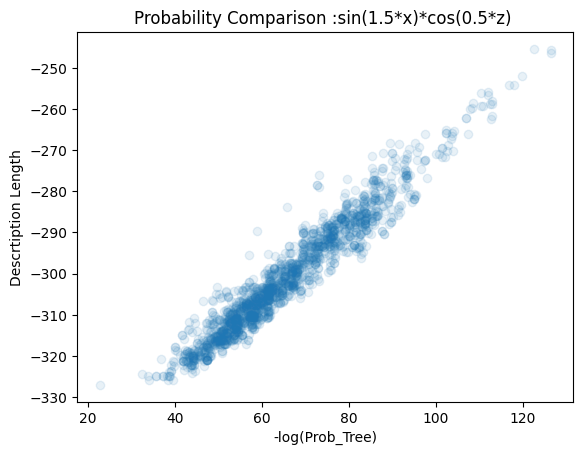

In [62]:
with open(ProbTreeFile, 'rb') as f:
    probTree = pickle.load(f)

all_desc_length_y=[]
all_probtree_prob = []


with open(filtered_new_expressions_file, 'r') as f:
    for line in f:
        desc_length , expression = float(line.strip().split("||")[0]) , line.strip().split("||")[1]
        all_desc_length_y.append(desc_length)
        probTree.tree.build_from_string(expression)
        all_probtree_prob.append(probTree.pr_tree())

minus_log_probtree_x = -1* np.log(all_probtree_prob)
plot_graph(minus_log_probtree_x, all_desc_length_y, probtreefile=ProbTreeFile, savedir="./KL/Prob_Comparison/M2/GAUSSIAN STEPS/")

## M3

In this case the procedure has been the following.
1. Generate a set of expressios with the BMS using a dataset (NGuyen^C)
2. Train a tree with each of these datasets.
3. Generate random expressions with the tree.
4. Compare probabilities of these new expressions between the tree and the BMS.

In [50]:
ProbTreeFile = "./KL/Probabilty_Trees/GAUSSIAN STEPS/sin(1.5*x)*cos(0.5*z)_nv2_np20_mean0_stddev0.1.txt_GAUSSIAN_STEPS"
expressions_file = './KL/Generated_expressions/NOU_ARBRE'

./KL/Prob_Comparison/M3/GAUSSIAN STEPS/sin(1.5*x)*cos(0.5*z).png


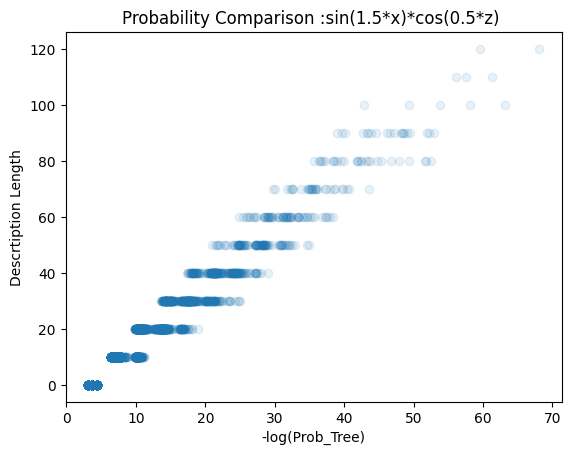

In [94]:
with open(ProbTreeFile, 'rb') as f:
    probTree = pickle.load(f)

all_desc_length_y=[]
all_probtree_prob = []

with open(expressions_file, 'r') as f:
    for line in f:
        expression = line.strip()
        probTree.tree.build_from_string(expression)
        bms = probTree.tree
        bms.get_sse(fit = True)
        bms.get_bic(fit = False)
        bms.get_energy(reset= True)
        all_desc_length_y.append(bms.E)
        all_probtree_prob.append(probTree.pr_tree())

minus_log_probtree_x = -1* np.log(all_probtree_prob)
plot_graph(minus_log_probtree_x, all_desc_length_y, probtreefile=ProbTreeFile, savedir="./KL/Prob_Comparison/M3/GAUSSIAN STEPS/")


./KL/Prob_Comparison/M3/GAUSSIAN STEPS/FITXER/prova.png


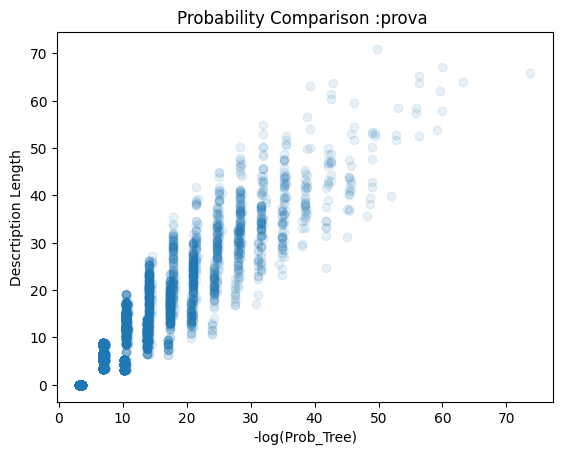

In [54]:
'''
with open(ProbTreeFile, 'rb') as f:
    probTree = pickle.load(f)
'''
all_desc_length_y=[]
all_probtree_prob = []

with open(expressions_file, 'r') as f:
    for line in f:
        expression = line.strip()
        Arbre.tree.build_from_string(expression)
        bms = Arbre.tree
        bms.get_sse(fit = True)
        bms.get_bic(fit = False)
        bms.get_energy(reset= True)
        all_desc_length_y.append(bms.E)
        all_probtree_prob.append(Arbre.pr_tree())

minus_log_probtree_x = -1* np.log(all_probtree_prob)
plot_graph(minus_log_probtree_x, all_desc_length_y, probtreefile=ProbTreeFile, savedir="./KL/Prob_Comparison/M3/GAUSSIAN STEPS/FITXER")

## M3 modified version for new experiment

In [5]:
#Chargind dataset
XLABS = ['x']
df = pd.read_csv("./New_Experiment/sin(1.5*x)*cos(0.5*z).csv")
x = df[XLABS]
y = df['y']


In [3]:
#config preparation
parameters=['a%d' % i for i in range(20)]
parameter_path = './Prior/final_prior_param_sq.named_equations.nv2.np20.2016-09-16 10:25:20.190011.dat'
prior_par = read_prior_par(parameter_path)

In [4]:
bms = Tree(
    variables = XLABS,
    parameters = parameters,
    x = x, y = y,
    prior_par = prior_par
)


In [15]:
expressions_file = "./New_Experiment/Generated_expressions_nv2_np20.txt"

In [16]:
bms_desc_lengths = []
minus_log_prob_tree = []
valid_expressions = []

with open(expressions_file, 'r') as f:
    for line in f:
        expression, neg_log_prob_tree = str(line.strip().split("||")[0]), -np.log(float( line.strip().split("||")[1]))        
        bms.build_from_string(expression)
        bms.get_sse(fit = True, verbose = False)
        bms.get_bic(fit = False)
        bms.get_energy(reset= True)       
        if ("*I" not in str(bms.E) and bms.E < 5000):
            valid_expressions.append(expression)
            minus_log_prob_tree.append(neg_log_prob_tree)
            bms_desc_lengths.append(bms.E)
        

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

In [18]:
with open("./New_Experiment/Prob_Comparison_sin(1.5*x)*cos(0.5*z).csv", "w") as f:
    f.write("bms_E,minus_log_prob_tree,expression\n")
    for x, y, z in zip(bms_desc_lengths, minus_log_prob_tree, valid_expressions):
        f.write(f"{x},{y}, {z}\n")

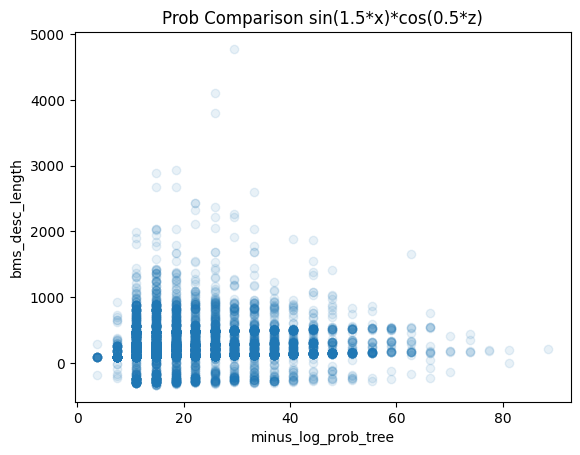

In [19]:
plt.scatter(minus_log_prob_tree, bms_desc_lengths, alpha = 0.1)
plt.xlabel("minus_log_prob_tree")
plt.ylabel("bms_desc_length")
plt.title("Prob Comparison sin(1.5*x)*cos(0.5*z)")
plt.savefig("./New_Experiment/Prob_Comparison_sin(1.5*x)*cos(0.5*z).png")
plt.show()

# New experiment comparison

In [2]:
def comparison(file, tree_file, title):
    df = pd.read_csv(file)
    expressions = df['expression'].str.strip()
    desc_length = df['bms_E']
    
    with open(tree_file, 'rb') as f:
        arbreprob = pickle.load(f)
    
    minus_log_prob_trees = -np.log(expressions.apply(lambda expr: arbreprob.prob_expression(expr)))

    '''
    # FILTRAT OPCIONAL
    filtered_minus_log, filtered_desc_length = [], []
    for minus_log, energy in zip(minus_log_prob_trees, desc_length):
        if energy < 500:
            filtered_minus_log.append(minus_log)
            filtered_desc_length.append(energy)
    minus_log_prob_trees = filtered_minus_log
    desc_length = filtered_desc_length
    '''

    # Primer scatter: datos calculados con arbreprob
    plt.scatter(minus_log_prob_trees, desc_length, alpha=0.1, label='ProbTree trained')

    # Segundo scatter: datos del archivo file2
    df2 = pd.read_csv(file)
    expressions2 = df2['expression'].str.strip()
    desc_length2 = df2['bms_E']
    minus_log_default_prob_tree2 = df2['minus_log_prob_tree']

    plt.scatter(minus_log_default_prob_tree2, desc_length2, alpha=0.1, label='Probtree without training')

    # Añadir leyenda
    plt.title(title)
    plt.xlabel('-log(probability)')
    plt.ylabel('Description length')
    plt.legend()


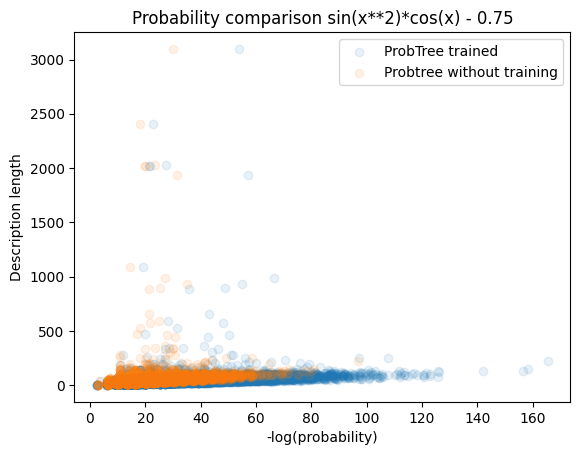

In [3]:
probComparisonFile = "./New_Experiment/Prob_Comparison_sin(x**2)*cos(x) - 0.75.csv"
treeFile = "./New_Experiment/Prob_Trees/Prob_Tree_sin(x**2)*cos(x) - 0.75"
plot_Title = "Probability comparison sin(x**2)*cos(x) - 0.75"

comparison(file=probComparisonFile, tree_file =treeFile, title = plot_Title)
plt.savefig('./New_Experiment/Prob Comparison Trained Trees/Prob_Comparision_Trained_sin(x**2)*cos(x) - 0.75.png')
plt.show()

In [20]:
file_tree = "./New_Experiment/Prob_Trees/Prob_Tree_sqrt(1.23*x)"
with open(file_tree, 'rb') as f:
        arbreprob = pickle.load(f)

In [21]:
print("Gaussian Steps")
print("Probability list of the root of sqrt(1.23*x)")
arbreprob.root.prob_list

Gaussian Steps
Probability list of the root of sqrt(1.23*x)


{'_a0_': 0.06609698062693269,
 '_a1_': 0.06688417891159128,
 '_a2_': 0.06342209122452815,
 '_a3_': 0.06349070945707783,
 '_a4_': 0.07000458155462566,
 '_a5_': 0.07168384250854719,
 '_a6_': 0.0671279425974913,
 '_a7_': 0.06479782776941428,
 '_a8_': 0.06920410486466406,
 '_a9_': 0.062059291268398535,
 'x': 0.026867548647667126,
 'sin': 0.008415364515613147,
 'cos': 1.0361153674839403e-06,
 'tan': 0.011944249974943205,
 'exp': 1.0650158675193464e-06,
 'log': 1.3367754350021491e-06,
 'sinh': 0.0105188105930832,
 'cosh': 0.029965416703148624,
 'tanh': 1.0082021306546616e-06,
 'pow2': 0.006114873128190762,
 'pow3': 1.048619589540916e-06,
 'abs': 1.2659532189447115e-06,
 'sqrt': 0.08076695152182244,
 'fac': 0.012960154883468902,
 '-': 1.0012648219852529e-06,
 '+': 0.008573719781089858,
 '*': 0.06204128973033253,
 '/': 0.009050262586637985,
 '**': 0.0680020452043002}

In [22]:
print("Random Steps")
print("Probability list of the root of sqrt(1.23*x)")
file_tree = "./KL/Probabilty_Trees/ sqrt(1.23*x)_nv1_np10_mean0_stddev0.1.txt_GREEDY"
with open(file_tree, 'rb') as f:
        arbreprob = pickle.load(f)
arbreprob.root.prob_list

Random Steps
Probability list of the root of sqrt(1.23*x)


{'x': 0.012784697526432876,
 '_a0_': 0.012784697526432876,
 '_a1_': 0.012784697526432876,
 '_a2_': 0.012784697526432876,
 '_a3_': 0.012784697526432876,
 '_a4_': 0.012784697526432876,
 '_a5_': 0.012784697526432876,
 '_a6_': 0.012784697526432876,
 '_a7_': 0.012784697526432876,
 '_a8_': 0.012784697526432876,
 '_a9_': 0.012784697526432876,
 '_a10_': 0.012784697526432876,
 '_a11_': 0.012784697526432876,
 '_a12_': 0.012784697526432876,
 'sin': 0.018656885060586742,
 'cos': 0.018656885060586742,
 'tan': 0.018656885060586742,
 'exp': 0.018656885060586742,
 'log': 0.018656885060586742,
 'sinh': 0.017822774666686924,
 'cosh': 0.018656885060586742,
 'tanh': 0.018656885060586742,
 'pow2': 0.027142339487276082,
 'pow3': 0.018656885060586742,
 'abs': 0.03694579427628066,
 'sqrt': 0.018656885060586742,
 'fac': 0.018656885060586742,
 '-': 0.018656885060586742,
 '+': 0.018656885060586742,
 '*': 0.018656885060586742,
 '/': 0.018656885060586742,
 '**': 0.47790693535148177}